# Project 02 - Image segmentation and object detection

__Handout date:__ 23.05.2024  
__Submission deadline:__ 19.06.2024 - 23:59  
__Topics:__ Segmentation and object detection.  
__Submission link:__ https://fz-juelich.sciebo.de/s/410NfCTI5rMLv1n

In this project, we would like you to investigate image segmentation and object detection.
For this, you will use the data from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC039).
The dataset contains images of cells acquired using fluorescence microscopy, along with annotations of individual cells.
Your goal will be to apply the segmentation and detection methods described in the lecture to the dataset.

__Note:__ The main goal of this project to get you working on a real-world segmentation/detection task. Projects will not be graded based on the performance of the trained classifiers.

![A stack of images](./broad_dataset.png)

We suggest that you follow the following  steps:
1. __Know your data__ Have a look  at the resources provided on the website to understand the dataset.
1. Download and inspect the images, groundtruth annotations, and metadata. Plot a few example datapoints. __Tip:__ The data has fixed URLs, so you can download the data from within the notebook (e.g., using `!wget URL`).
1. Write a data loader that allows you to use the data in PyTorch. Split the data according to the training, test, and validation files provided in the metadata.
1. Train one or multiple of the segmentation models discussed in the lecture (or any other segmentation model you would like to try) to segment the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s).
1. Train one of multiple of the detection models discussed in the lecture (or any other detection method you would like to try) to detect the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s).

Tipps and hints:
1. Please do not add the dataset to your submission. Use `.gitignore` to ignore the directory containing the downloaded dataset.
1. Think about how you have to process the provided groundtruth data to make it usable for segmentation and detection.
1. `scikit-image` provides several helpful functions for extracting information from masks. Have a look at `skimage.measure.label` and `skimage.measure.regionprops`. These can help to convert data into a format that is appropriate for detection.

In [ ]:
# download the data from Broad Institute
!wget https://data.broadinstitute.org/bbbc/BBBC039/images.zip
!wget https://data.broadinstitute.org/bbbc/BBBC039/metadata.zip
!wget https://data.broadinstitute.org/bbbc/BBBC039/masks.zip
!unzip -q images.zip
!unzip -q metadata.zip
!unzip -q masks.zip
!rm images.zip metadata.zip masks.zip
!pip install torchmetrics

In [1]:
# import packages

import os
import torch
from torch import nn
from torch.nn.functional import relu
import numpy as np
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io
import skimage.morphology
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [ ]:
## Prepare the input images
img_dir = 'images'
out_dir = 'images_processed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    out_path = os.path.join(out_dir, img_name.split('.')[0] + '.png')
    img = skimage.io.imread(img_path)
    img = skimage.exposure.rescale_intensity(img, out_range=(0, 255))
    skimage.io.imsave(out_path, img.astype(np.uint8))

## Prepare the 3-class masks
def create_mask(img_path, out_path):
    img = skimage.io.imread(img_path)

    # the mask is the first channel of the image
    img = img[:, :, 0]

    # threshold the image
    img = skimage.morphology.label(img)
    img = skimage.morphology.remove_small_objects(img)
    img = skimage.morphology.binary_erosion(img)
    boundaries = skimage.segmentation.find_boundaries(img)
    label_binary = np.zeros((img.shape))

    # create the 3-class mask
    label_binary[(img == 0) & (boundaries == 0)] = 0
    label_binary[(img != 0) & (boundaries == 0)] = 1
    label_binary[boundaries == 1] = 2
    # save the mask
    skimage.io.imsave(out_path, label_binary.astype(np.uint8))

# create the mask for each image
img_dir = 'masks'
mask_dir = 'masks_processed'

if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    out_path = os.path.join(mask_dir, img_name)
    create_mask(img_path, out_path)

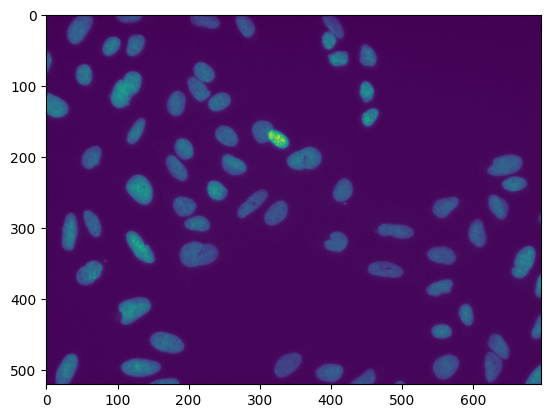

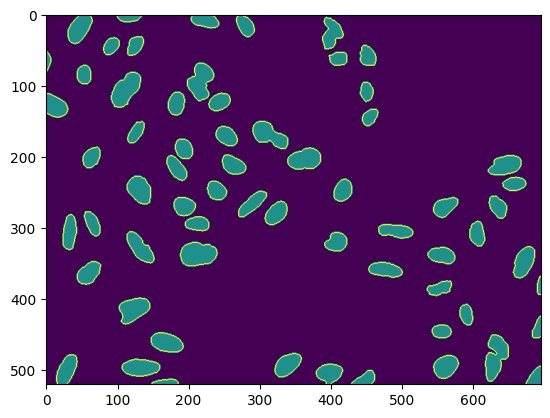

In [2]:
## create a dataloader using pytorch
class nucleiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, metadata_file, transform=T.ToTensor()):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.metadata = pd.read_csv(metadata_file)
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.metadata.iloc[idx, 0])
        mask_name = os.path.join(self.mask_dir, self.metadata.iloc[idx, 0])
        image = Image.open(img_name)
        mask = read_image(mask_name).squeeze()
        if self.transform:
            image = self.transform(image)
            # mask = self.transform(mask)
        return image, mask

# create the total dataset
dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='metadata/filenames_and_plates.csv')

# show the first image and mask
image, mask = next(iter(dataset))
plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(mask.permute(0, 1))
plt.show()


# split the dataset into train and test
train_dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='./metadata/training.txt')
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='./metadata/validation.txt')
val_dl = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='./metadata/test.txt')
test_dl = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [3]:
## Use U-Net to segment the nuclei

# the codes are copied from the former U-Net implementation in DL course
# con2d layer
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel=0, bias=True,
                    up=False, down=False, pooling=True, bilinear=True):
        """
        Args:
            in_channels:        Number of input channels for this block.
            out_channels:       Number of output channels for this block.
            kernel:             Kernel size for the first convolution.
            bias:               Bias parameter for the convolution.
            up/down:            Whether the first convolution is in up- or down-sampling mode.
        """
        super().__init__()
        assert not (up and down), 'up and down cannot be both True'
        assert not (kernel and (up or down)), 'Cannot use kernel with up/down sampling'
        assert kernel or up or down, 'Must use kernel or up or down sampling'
        conv_kwargs = dict(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=bias
        )
        self.resize = nn.Identity()
        conv_type = nn.Conv2d
        # Down-sampling case
        if down:
            conv_kwargs.update(kernel_size=3, padding=1)
            if pooling:
                self.resize = nn.MaxPool2d(2)
            else:
                conv_kwargs['stride'] = 2
        # Up-sampling case
        elif up:
            if bilinear:
                self.resize = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                conv_kwargs.update(kernel_size=3, padding=1)
            else:
                conv_kwargs.update(kernel_size=2, stride=2)
                conv_type = nn.ConvTranspose2d
        elif kernel:
            conv_kwargs.update(kernel_size=kernel, padding=kernel // 2)
        self.conv = conv_type(**conv_kwargs)

    def forward(self, x):
        return self.conv(self.resize(x))

# UNet block
class UNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel=0, up=False, down=False,
                         dropout=0, eps=1e-5, bilinear=True, pooling=True):
        """
        Args:
            in_channels:        Number of input channels for this block.
            out_channels:       Number of output channels for this block.
            kernel:             Kernel size for the first convolution.
            up/down:            Whether the first convolution is in up- or down-sampling mode.
            dropout:            Dropout probability for dropout before the second conv.
            eps:                Epsilon parameter for BatchNorm2d.
        """
        super().__init__()
        self.norm0 = nn.BatchNorm2d(in_channels, eps)
        self.conv0 = Conv2d(in_channels, out_channels, kernel,
                            up=up, down=down,
                            bilinear=bilinear, pooling=pooling)
        self.norm1 = nn.BatchNorm2d(out_channels, eps)
        self.conv1 = Conv2d(out_channels, out_channels, 3)
        self.dropout = dropout
        self.out_channels = out_channels

        self.res = not (out_channels != in_channels or up or down)


    def forward(self, x):
        orig = x
        x = self.conv0(relu(self.norm0(x)))  # in-conv
        x = relu(self.norm1(x))
        x = self.conv1(torch.nn.functional.dropout(x, p=self.dropout, training=self.training))  # optional dropout
        if self.res:
            x = x + orig  # optional residual connection
        return x


# And finally the U-Net model
class UNet(torch.nn.Module):
    def __init__(self, resolution, in_channels, out_channels, kernel_size=3, base_channels=32, channel_mult=[1,2,4], num_blocks=1, dropout=0.10,
                 pooling=True, bilinear=True):
        """
        Args:
            resolution:     Image resolution at input/output.
            in_channels:    Number of color channels at input.
            out_channels:   Number of color channels at output.
            kernel_size:    Convolution kernel size.
            base_channels:  Base multiplier for the number of channels.
            channel_mult:   Per-resolution multipliers for the number of channels.
            num_blocks:     Number of residual blocks per resolution.
            dropout:        Dropout probability of intermediate activations.
        """
        super().__init__()
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        # Encoder.
        self.enc = torch.nn.ModuleDict()
        cout = in_channels
        for level, mult in enumerate(channel_mult):
            res = resolution >> level  # really nice way of computing the resolution at each level
            if level == 0:
                cin = cout
                cout = base_channels
                self.enc[f'{res}x{res}_in_conv'] = Conv2d(in_channels=cin, out_channels=cout, kernel=kernel_size)
            else:
                self.enc[f'{res}x{res}_down'] = UNetBlock(in_channels=cout, out_channels=cout, down=True, dropout=dropout, pooling=pooling)
            for idx in range(num_blocks):
                cin = cout
                cout = base_channels * mult
                self.enc[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, kernel=kernel_size, dropout=dropout)
        skips = [block.out_channels for name, block in self.enc.items() if f'block{num_blocks-1}' in name]  # Last UNetBlock in each level

        # Decoder.
        self.dec = torch.nn.ModuleDict()
        for level, mult in reversed(list(enumerate(channel_mult))):
            res = resolution >> level
            if level == len(channel_mult) - 1:
                self.dec[f'{res}x{res}_bottleneck0'] = UNetBlock(in_channels=cout, out_channels=cout, kernel=kernel_size, dropout=dropout)
                self.dec[f'{res}x{res}_bottleneck1'] = UNetBlock(in_channels=cout, out_channels=cout, kernel=kernel_size, dropout=dropout)
            else:
                self.dec[f'{res}x{res}_up'] = UNetBlock(in_channels=cout, out_channels=cout, up=True, dropout=dropout, bilinear=bilinear)
            for idx in range(num_blocks):
                cin = cout if idx != 0 else cout + skips.pop()  # First UNetBlock in each level
                cout = base_channels * mult
                self.dec[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, kernel=kernel_size, dropout=dropout)
            if level == 0:
                self.dec[f'{res}x{res}_out_norm'] = nn.BatchNorm2d(num_features=cout, eps=1e-6)
                self.dec[f'{res}x{res}_out_conv'] = nn.Sequential(nn.ReLU(), Conv2d(in_channels=cout, out_channels=out_channels, kernel=3))

    def forward(self, x):
        # Encoder.
        skips = []
        for name, block in self.enc.items():
            x = block(x) if isinstance(block, UNetBlock) else block(x)
            if f'block{self.num_blocks-1}' in name:  # Last UNetBlock in each level
                skips.append(x)
        # Decoder.
        for name, block in self.dec.items():
            if 'block0' in name:  # First UNetBlock in each level
                x = torch.cat([x, skips.pop()], dim=1)
            x = block(x)
        return x

In [58]:
# consturct the U-Net model
model = UNet(resolution=310, in_channels=1, out_channels=3, kernel_size=3, base_channels=16, channel_mult=[1,2,4], num_blocks=2, dropout=0.10,
                 pooling=True, bilinear=True).to('cuda')

In [17]:
## training and validation
def validate(model, val_loader, device, criterion, metric):
    loss_step, metric_step = [], []
    model.eval()

    with torch.no_grad():
        for inp_data, labels in val_loader:
            # Move imgs and labels to gpu
            labels = labels.to(device).long()
            inp_data = inp_data.to(device)
            # Forward pass
            outputs = model(inp_data)
            # Calculate and record loss and metrics
            metric_step.append(metric(outputs, labels.long()).item())
            loss_step.append(criterion(outputs, labels).item())

    val_loss_epoch = np.mean(loss_step)
    val_metric = np.mean(metric_step)
    return val_loss_epoch, val_metric

def train_one_epoch(model, optimizer, train_loader, device, criterion, metric):
    loss_step, metric_step = [], []
    model.train()
    for (inp_data, labels) in train_loader:
        # Move imgs and labels to gpu
        labels = labels.to(device).long()
        inp_data = inp_data.to(device)
        # Forward pass
        outputs = model(inp_data)
        loss = criterion(outputs, labels)
        # Compute gradients and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Compute and record metric and loss
        metric_step.append(metric(outputs, labels.long()).item())
        loss_step.append(loss.item())

    loss_curr_epoch = np.mean(loss_step)
    train_metric = np.mean(metric_step)
    return loss_curr_epoch, train_metric

def train(model, optimizer, num_epochs, train_loader, val_loader, device, criterion, metric, exp_name='unet', viz=False, viz_freq=20):
    best_val_metric = -1
    model = model.to(device)
    dict_log = {"train_metric":[], "val_metric":[], "train_loss":[], "val_loss":[]}
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        train_loss, train_metric = train_one_epoch(model, optimizer, train_loader, device, criterion, metric)
        val_loss, val_metric,  = validate(model, val_loader, device, criterion, metric)
        msg = (f'Ep {epoch}/{num_epochs}: metric : Train:{train_metric:.3f} \t Val:{val_metric:.2f}\
                || Loss: Train {train_loss:.3f} \t Val {val_loss:.3f}')

        pbar.set_description(msg)

        dict_log["train_metric"].append(train_metric)
        dict_log["val_metric"].append(val_metric)
        dict_log["train_loss"].append(train_loss)
        dict_log["val_loss"].append(val_loss)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  'metric':val_metric,
                  }, f'{exp_name}_best_model_min_val_loss.pth')
        if viz and (epoch+1) % viz_freq==0:
            show_preds(model, train_loader, device, num_samples=1)

    return dict_log

In [25]:
def plot_stats(dict_log, modelname="",baseline=None, title=None, scale_metric=100):
    plt.figure(figsize=(15,10))
    fontsize = 14
    plt.subplots_adjust(hspace=0.3)
    plt.subplot(2,1,1)
    x_axis = list(range(len(dict_log["val_metric"])))

    y_axis_train = [i * scale_metric for i in dict_log["train_metric"]]
    y_axis_val = [i * scale_metric for i in dict_log["val_metric"]]
    plt.plot(y_axis_train, label=f'{modelname} Train mIoU')
    plt.scatter(x_axis, y_axis_train)

    plt.plot( y_axis_val, label=f'{modelname} Validation mIoU')
    plt.scatter(x_axis, y_axis_val)

    plt.ylabel('mIoU in %')
    plt.xlabel('Number of Epochs')
    plt.title("mIoU over epochs", fontsize=fontsize)
    if baseline is not None:
        plt.axhline(y=baseline, color='red', label="Acceptable performance")
    plt.legend(fontsize=fontsize, loc='best')

    plt.subplot(2,1,2)
    plt.plot(dict_log["train_loss"] , label="Training")


    plt.scatter(x_axis, dict_log["train_loss"], )
    plt.plot(dict_log["val_loss"] , label='Validation')
    plt.scatter(x_axis, dict_log["val_loss"])

    plt.ylabel('Loss value')
    plt.xlabel('Number of Epochs')
    plt.title("Loss over epochs", fontsize=fontsize)
    plt.legend(fontsize=fontsize, loc='upper right')

Ep 49/50: metric : Train:0.845 	 Val:0.83                || Loss: Train 0.061 	 Val 0.068: 100%|██████████| 50/50 [09:05<00:00, 10.92s/it]


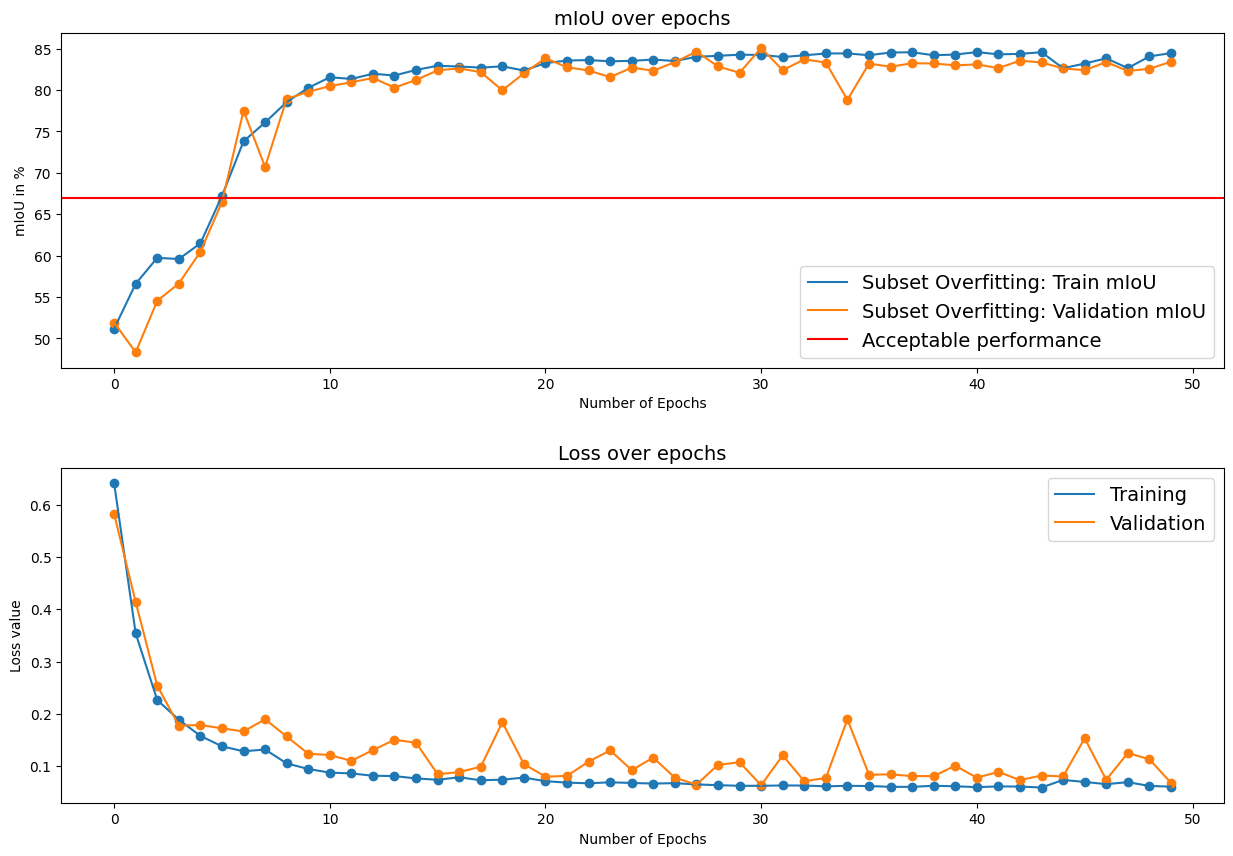

In [59]:
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex as iou
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
metric = iou(num_classes=3).to(device)
epochs = 50
dict_log = train(model, optimizer, epochs, train_dl, val_dl, device, criterion, metric, exp_name='UNet-ce-ovefit')
plot_stats(dict_log, modelname="Subset Overfitting:", baseline=67, scale_metric=100, title="./figs/so")

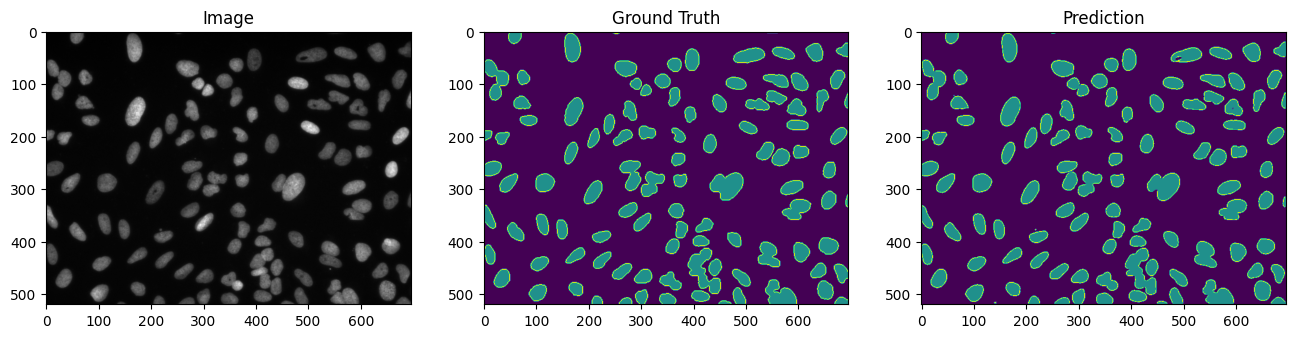

In [60]:
# Plot a sample of prediction
model.eval()
model = model.to(device)
imgs, segs = next(iter(val_dl))
preds = model(imgs.to(device))
pred = preds.argmax(dim=1)[0].cpu()

label_binary = np.zeros((pred.shape))
label_binary[pred == 1] = 1
label_binary[pred == 2] = 2

img, seg = imgs[0], segs[0]

fig, ax = plt.subplots(1, 3, figsize = (16, 16))
ax[0].imshow(img.permute(1, 2, 0), cmap = "gray")
ax[1].imshow(seg)
ax[2].imshow(label_binary)
ax[0].title.set_text('Image')
ax[1].title.set_text('Ground Truth')
ax[2].title.set_text('Prediction')

plt.show()

In [43]:
# Garbage collection
import gc

gc.collect()

torch.cuda.empty_cache()
